In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import Normalizer
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Flatten

In [5]:
PATH = '<path to dataset>'
PATH_SAVE = '<path to saved model>'
HISTORY = 5
TARGET = 3
STEP = 1
EPOCHS = 300
LR = 10e-4
BATCH_SIZE = 32
# BUFFER_SIZE = 10_000
SPLIT_FRACTION = 0.8

In [6]:
df = pd.read_csv(PATH)

In [8]:
data = df[['DiffuseSolarRadAvg', 'SolarRadAvg', 'WindSpeedAvg',
       'TemperatureAvg', 'LeafInfraredAvg',
       'RelHumidityAvg', 'LeafWetness']]

In [9]:
x = data.index

In [10]:
data_array = data.values

In [18]:
# difsolar = data['DiffuseSolarRadAvg'].values
leaf = data['LeafInfraredAvg'].values
# solar = data['SolarRadAvg'].values
temperature = data['TemperatureAvg'].values

In [11]:
TRAIN_SPLIT = int(SPLIT_FRACTION * data.shape[0])

In [19]:
coef = np.polyfit(x, temperature, deg=3)
p = np.poly1d(coef)

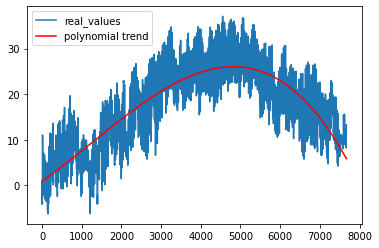

In [20]:
plt.plot(x, temperature)
plt.plot(x, p(x), '-', c='r')
plt.legend(['real_values', 'polynomial trend'])
plt.show()

In [21]:
trend_temp = p(x)

In [22]:
coef = np.polyfit(x, leaf, deg=3)
p = np.poly1d(coef)

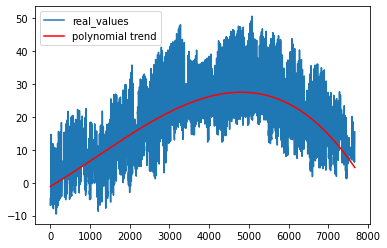

In [23]:
plt.plot(x, leaf)
plt.plot(x, p(x), '-', c='r')
plt.legend(['real_values', 'polynomial trend'])
plt.show()

In [24]:
trend_leaf = p(x)

In [26]:
detrtemp = temperature - trend_temp
detrleaf = leaf - trend_leaf

In [27]:
data_array[:, 3] = detrtemp
data_array[:, 4] = detrleaf

In [28]:
scaler = Normalizer()
scaler.fit(data_array[:TRAIN_SPLIT])
data_normalized = scaler.transform(data_array)

In [31]:
train_set = data_normalized[:TRAIN_SPLIT]
valid_set = data_normalized[TRAIN_SPLIT:]

In [32]:
start = HISTORY
end = TRAIN_SPLIT + TARGET
y_train = data_normalized[start:end]
sequence_length = int(HISTORY / STEP)

In [33]:
dataset_train = tf.keras.preprocessing.timeseries_dataset_from_array(
    train_set,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=STEP,
    batch_size=BATCH_SIZE,
)

In [34]:
label_start = TRAIN_SPLIT + HISTORY + TARGET

x_val = valid_set[:-TARGET]
y_val = data_normalized[label_start:]

In [35]:
dataset_val = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=STEP,
    batch_size=BATCH_SIZE,
)

In [36]:
inputs = Input(shape=(HISTORY, train_set.shape[1]))
# inputs = tf.keras.layers.Input(shape=(inputs.shape[1], 1))
lstm_01 = LSTM(600, activation='tanh', return_sequences=True)(inputs)
lstm_02 = LSTM(400, activation='tanh', return_sequences=False)(lstm_01)
# lstm_03 = LSTM(200, activation='tanh', return_sequences=False)(lstm_02)
flatten = Flatten()(lstm_02)
dropout = Dropout(0.3)(flatten)
dense_01 = Dense(128)(dropout)
dense_02 = Dense(64)(dense_01)
outputs = Dense(7, activation='linear')(dense_02)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [37]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [39]:
callback_01 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

callback_02 = tf.keras.callbacks.ModelCheckpoint(
    PATH_SAVE,
    monitor="val_loss",
    mode = 'min',
    save_best_only=True,
)

callback_03 = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=10,
    verbose=0,
    mode="min",
    min_delta=10e-4
)

In [1]:
history = model.fit(
    dataset_train,
    epochs=EPOCHS,
    validation_data=dataset_val,
    callbacks=[callback_02],
    verbose=1
)